In this notebook, we used transfer learning(Inception_v3) to detect tumors. 

TODO(12.8):
* Write functions to get slide a window across the slide. Extract patches and labels (using the tissue mask).
* Normal and tumor class imbalance problem: sampling. 
* Build pre-trained model. 
* Evaluation and Predictions. 
* Get heatmap at level 7. 

---

ISSUES (12.8):
* How to get predictions for level 7 slide if we trained on level 5? 
* Different tumor slide is not the same size! 
* We do not have normal slide, how to resample accurately?









In [0]:
# # Install the OpenSlide C library and Python bindings
# !apt-get install openslide-tools
# !pip install openslide-python

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import keras
import urllib
import tensorflow as tf
import gc

Using TensorFlow backend.


In [0]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [0]:
#Download a test slide
# !pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

fname = 'tumor_059.tif'
if not os.path.exists(fname): 
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # file_list = drive.ListFile(
  #     {'q': "'1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5' in parents"}).GetList()

  f_ = drive.CreateFile({'id': '19La9AncyGh3wc53sYJKMp-toJceDX7az'})
  f_.GetContentFile(fname)
  fname = 'tumor_059_mask.tif'
  f_ = drive.CreateFile({'id': '1RINiVrs7cWXQ9iXjBWcCR2WVbP_8k_QT'})
  f_.GetContentFile(fname)
  
fname = 'tumor_078.tif'
if not os.path.exists(fname):
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  f_ = drive.CreateFile({'id': '1cAFgPCkGR0zH0gqCDo4yBnstNoZmjp3C'})
  f_.GetContentFile(fname)
  fname = 'tumor_078_mask.tif'
  f_ = drive.CreateFile({'id': '1ZC2urznY3gRebUG3PN2BtYD1ZPZ7GPYq'})
  f_.GetContentFile(fname)

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
# We'll find non-tissue areas by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])
  
def extract_patches_labels(slide_image,mask_image,zoom_level,x=0,y=0,
                           window_size=299,center_size=128,stride=128):
  
  """This function will generate images from slide
  
  Arguments:
    slide_image, mask_image: images of slide and labels
    zoom_level: the level that we want to look at
    x,y: start coordinates
    window_size: size of the window used to get images from slide
    stride: step
      
  Returns:
    returns sub-images array from slide and their corresponding labels
    
  """
  num_grid= (((slide_image.shape[0]-window_size+1)//stride)+1)*(((slide_image.shape[1]-window_size+1)//stride)+1)
  imgs=np.zeros((num_grid,window_size,window_size,3))
  labels=np.zeros(num_grid)
  half_grid=center_size/2
  count=0
  
  for i in range(0,slide_image.shape[0]-window_size+1,stride):
    for j in range(0,slide_image.shape[1]-window_size+1,stride):
      x_pos=i+center_size
      y_pos=j+center_size
      grid_slide=slide_image[i:(i+window_size),j:(j+window_size),:]
      imgs[count,:,:,:]=grid_slide
      grid_label=mask_image[(x_pos-half_grid):(x_pos+half_grid),(y_pos-half_grid):(y_pos+half_grid)]
#       if np.mean(grid_label) >0.2:
#         labels[count]=1.
#       count += 1
      labels[count] = np.argmax([np.mean(grid_label==0), np.mean(grid_label==1)*128, np.mean(grid_label==2)/2])
      count += 1
    
  return imgs, labels

def extract_patches(slide_image,zoom_level,x=0,y=0,
                    window_size=299,center_size=128,stride=128):
  
  """This function will generate images from slide
  
  Arguments:
    slide_image, mask_image: images of slide and labels
    zoom_level: the level that we want to look at
    x,y: start coordinates
    window_size: size of the window used to get images from slide
    stride: step
      
  Returns:
    returns sub-images array from slide and their corresponding labels
    
  """
  num_grid= (((slide_image.shape[0]-window_size+1)//stride)+1)*(((slide_image.shape[1]-window_size+1)//stride)+1)
  imgs=np.zeros((num_grid,window_size,window_size,3))
  half_grid=center_size/2
  count=0
  
  for i in range(0,slide_image.shape[0]-window_size+1,stride):
    for j in range(0,slide_image.shape[1]-window_size+1,stride):
      x_pos=i+center_size
      y_pos=j+center_size
      grid_slide=slide_image[i:(i+window_size),j:(j+window_size),:]
      imgs[count,:,:,:]=grid_slide
      #grid_label=mask_image[(x_pos-half_grid):(x_pos+half_grid),(y_pos-half_grid):(y_pos+half_grid)]
#       if np.mean(grid_label) >0.2:
#         labels[count]=1.
#       count += 1
      #labels[count] = np.argmax([np.mean(grid_label==0), np.mean(grid_label==1)*128, np.mean(grid_label==2)/2])
      count += 1
    
  return imgs

In [0]:
## version 3.0
def sample_image_withnoise(img, label, noise = 0, control = True):
  """
  Use sampling(with replacement) to convert unbanlanced data to banlanced data
  input:
    img: np.array, n*width*height*channel
    label: np.array, n*1
    nums: number of samples
  output:
    sample_img: np.array, n*width*height*channel
    sample_label: label: np.array, n*1
  """
  n,w,h,c = img.shape
  sample_img = []
  positive_ind = [index for index, value in enumerate(label) if value == 1]
  negative_ind = [index for index, value in enumerate(label) if value == 0]
  invalid_ind = [index for index, value in enumerate(label) if value == 2]
  
  if control:
    nums = 2000
  else:
    nums = n
  sample_label = np.random.choice([0.,1.,2.0], nums)
  
  for flag in sample_label:
    if flag == 0:
      ind = np.random.choice(positive_ind,1)[0]
      sample_img.append( img[ind,:,:,:] + np.random.uniform(0,127.5,w*h*c).reshape(w,h,c) * noise  )
    elif flag == 1:
      ind = np.random.choice(negative_ind,1)[0]
      sample_img.append( img[ind,:,:,:] + np.random.uniform(0,127.5,w*h*c).reshape(w,h,c) * noise )
    else:
      ind = np.random.choice(invalid_ind,1)[0]
      sample_img.append( img[ind,:,:,:] + np.random.uniform(0,127.5,w*h*c).reshape(w,h,c) * noise )
      
#   sample_img = img[ind_list,:]

  del img
  gc.collect()
  sample_img = np.array(sample_img)
  return(sample_img, sample_label)

In [0]:
#Download a test slide
# !pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# file_list = drive.ListFile(
#     {'q': "'1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5' in parents"}).GetList()

fname = 'tumor_078.tif'
if not os.path.exists(fname): 
  f_ = drive.CreateFile({'id': '1cAFgPCkGR0zH0gqCDo4yBnstNoZmjp3C'})
  f_.GetContentFile(fname)
  fname = 'tumor_078_mask.tif'
  f_ = drive.CreateFile({'id': '1ZC2urznY3gRebUG3PN2BtYD1ZPZ7GPYq'})
  f_.GetContentFile(fname)

In [0]:
## convert labels to mask
def label2mask(y_pred, mask_size, center_size = 128, window_size = 299, stride = 128, center = True):
  
  if center:
    half_grid=center_size/2
  else:
    half_grid=window_size/2
    
  mask_pred=np.zeros(mask_size)
  
  count=0
  for i in range(0,mask_size[0]-window_size+1,stride):
    for j in range(0,mask_size[1]-window_size+1,stride):
      x_pos=i+center_size
      y_pos=j+center_size

      mask_pred[(x_pos-half_grid):(x_pos+half_grid),(y_pos-half_grid):(y_pos+half_grid)]=y_pred[count]
      
      count += 1
  return(mask_pred)

### concate layers

In [0]:
### layers defination

input_shape4 = 300

input4 = tf.keras.layers.Input(shape=(input_shape4, input_shape4, 3))
layer_level4 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(input_shape4, input_shape4, 3),
                 padding='same')(input4)
layer_level4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layer_level4)
layer_level4 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3),
                                    activation='relu',
                                    padding='same')(layer_level4)
layer_level4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layer_level4)

input5 = tf.keras.layers.Input(shape=(input_shape4/2, input_shape4/2, 3))
layer_level5 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(input_shape4/2, input_shape4/2, 3),
                 padding='same')(input5)
layer_level5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layer_level5)
layer_level5 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3),
                                    activation='relu',
                                    padding='same')(layer_level5)

added = tf.keras.layers.Add()([layer_level4, layer_level5])

combine_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(added)
combine_layer = tf.keras.layers.Flatten()(combine_layer)
combine_layer = tf.keras.layers.Dense(128, activation='relu')(combine_layer)
out = tf.keras.layers.Dense(3, activation='softmax')(combine_layer)
# out = tf.keras.layers.Dense(1, activation='sigmoid')(combine_layer)

combine_model = tf.keras.models.Model(inputs=[input4, input5], outputs=out)

import keras.backend as K

def custom_loss_4(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred) * 500)
  
combine_model.compile(optimizer=tf.train.RMSPropOptimizer(learning_rate=0.0001),
                      loss='sparse_categorical_crossentropy',
#                       loss=custom_loss_4,
#                       tf.nn.weighted_cross_entropy_with_logits(targets,logits,pos_weight）
                      metrics=['accuracy'])

### get data

In [0]:
slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

zoom_level = 4
slide_image4 = read_slide(slide, x=0, y=0, 
                         level=zoom_level, 
                         width=slide.level_dimensions[zoom_level][0], 
                         height=slide.level_dimensions[zoom_level][1])
mask_image4 = read_slide(tumor_mask, x=0, y=0, 
                        level=zoom_level, 
                        width=slide.level_dimensions[zoom_level][0], 
                        height=slide.level_dimensions[zoom_level][1])[:,:,0]

zoom_level = 5
slide_image5 = read_slide(slide, x=0, y=0, 
                         level=zoom_level, 
                         width=slide.level_dimensions[zoom_level][0], 
                         height=slide.level_dimensions[zoom_level][1])
mask_image5 = read_slide(tumor_mask, x=0, y=0, 
                        level=zoom_level, 
                        width=slide.level_dimensions[zoom_level][0], 
                        height=slide.level_dimensions[zoom_level][1])[:,:,0]

# mask_image = mask_image[:,:,0]
# mask_size = mask_image.shape

In [12]:
### assign label 2 for non-tissue areas
tissue_coor_list = find_tissue_pixels(slide_image4)
# w, h = mask_image4.shape
mask_image_triple4 = np.ones(mask_image4.shape) * 2

for (x, y) in tissue_coor_list:
  mask_image_triple4[x][y] = mask_image4[x][y]
  
del mask_image4
gc.collect()

0

In [13]:
### assign label 2 for non-tissue areas
tissue_coor_list = find_tissue_pixels(slide_image5)
# w, h = mask_image5.shape
mask_image_triple5 = np.ones(mask_image5.shape) * 2

for (x, y) in tissue_coor_list:
  mask_image_triple5[x][y] = mask_image5[x][y]
  
del mask_image5
gc.collect()

0

In [14]:
patches4, labels4 = extract_patches_labels(slide_image4,mask_image_triple4,zoom_level = 4,x=0,y=0,
                                         window_size=input_shape4,center_size=128,stride=128)
patches_res4,labels_res4=sample_image_withnoise(patches4, labels4, 0, False)  # without noise
del patches4
gc.collect()

0

In [15]:
patches5, labels5 = extract_patches_labels(slide_image5,mask_image_triple5,zoom_level = 5,x=0,y=0,
                                         window_size=input_shape4/2,center_size=64,stride=64)
patches_res5,labels_res5 = sample_image_withnoise(patches5, labels5, 0, False)  # without noise
del patches5
gc.collect()

0

In [16]:
epochs=20
batch_size=10

combine_model.fit([patches_res4/255,patches_res5/255],labels_res4,
                  batch_size=batch_size,epochs=epochs,validation_split=0.2)

Train on 537 samples, validate on 135 samples
Epoch 1/20
537/537 [==============================] - 8s 15ms/step - loss: 1.1089 - acc: 0.3538 - val_loss: 1.1870 - val_acc: 0.2741
Epoch 2/20
537/537 [==============================] - 5s 9ms/step - loss: 1.0590 - acc: 0.4097 - val_loss: 0.8912 - val_acc: 0.5185
Epoch 3/20
537/537 [==============================] - 5s 9ms/step - loss: 0.6384 - acc: 0.6648 - val_loss: 0.5595 - val_acc: 0.6370
Epoch 4/20
537/537 [==============================] - 5s 9ms/step - loss: 0.5236 - acc: 0.7207 - val_loss: 0.7388 - val_acc: 0.6370
Epoch 5/20
537/537 [==============================] - 5s 9ms/step - loss: 0.4960 - acc: 0.7449 - val_loss: 0.8530 - val_acc: 0.6370
Epoch 6/20
537/537 [==============================] - 5s 9ms/step - loss: 0.4541 - acc: 0.7542 - val_loss: 0.4536 - val_acc: 0.7630
Epoch 7/20
537/537 [==============================] - 5s 9ms/step - loss: 0.3684 - acc: 0.8268 - val_loss: 0.5191 - val_acc: 0.7259
Epoch 8/20
537/537 [=========

In [0]:
# slide_path_test='tumor_091.tif'
# mask_path_test='tumor_091_mask.tif'

slide_path_test='tumor_078.tif'
mask_path_test='tumor_078_mask.tif'

slide = open_slide(slide_path_test)
tumor_mask = open_slide(mask_path_test)

zoom_level = 4
slide_image4 = read_slide(slide, x=0, y=0, 
                         level=zoom_level, 
                         width=slide.level_dimensions[zoom_level][0], 
                         height=slide.level_dimensions[zoom_level][1]) / 255.0
mask_image4 = read_slide(tumor_mask, x=0, y=0, 
                        level=zoom_level, 
                        width=slide.level_dimensions[zoom_level][0], 
                        height=slide.level_dimensions[zoom_level][1])[:,:,0]

zoom_level = 5
slide_image5 = read_slide(slide, x=0, y=0, 
                         level=zoom_level, 
                         width=slide.level_dimensions[zoom_level][0], 
                         height=slide.level_dimensions[zoom_level][1]) / 255.0
# mask_image5 = read_slide(tumor_mask, x=0, y=0, 
#                         level=zoom_level, 
#                         width=slide.level_dimensions[zoom_level][0], 
#                         height=slide.level_dimensions[zoom_level][1])[:,:,0]

mask_size = mask_image4.shape

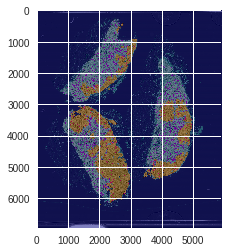

In [18]:
plt.imshow(slide_image4*255.0)
plt.imshow(mask_image4,cmap='jet',alpha=0.5)
plt.show()

In [19]:
patches5 = extract_patches(slide_image5,zoom_level = 5,x=0,y=0,
                              window_size=input_shape4/2,center_size=64,stride=64)
del slide_image5
gc.collect()

patches4,label_test = extract_patches_labels(slide_image4,mask_image4,zoom_level = 4,x=0,y=0,
                           window_size=input_shape4,center_size=128,stride=128)
del mask_image4
gc.collect()

0

In [20]:
y_pred_test_custom = combine_model.predict([patches4,patches5])

del patches4
gc.collect()
del patches5
gc.collect()

### convert logit to label
# y_pred_test_custom = np.argmax(y_pred_test_custom, axis=1)

mask_image_test_custom = label2mask(np.argmax(y_pred_test_custom,axis=1), mask_size, center_size = 128,
                                    window_size = input_shape4, stride = 128, center = True)

print(np.unique(np.argmax(y_pred_test_custom,axis=1),return_counts=True))

# del y_pred_test_custom
# gc.collect()

(array([0, 1, 2]), array([ 331,  504, 1453]))


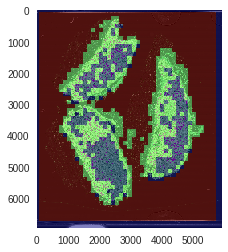

In [25]:
## CUSTOM model plot

plt.imshow(slide_image4*255.0)
plt.imshow(mask_image_test_custom,cmap='jet',alpha=0.5)
plt.grid(False)
plt.savefig('model_5_test.png')
plt.show()



In [0]:
# y_pred=np.round(y_pred_test_custom).copy()
# y_pred[y_pred_test_custom!=1]=0.
y_pred = np.argmax(y_pred_test_custom,axis = 1)

In [23]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(label_test, y_pred))


[[  86  353 1446]
 [ 245  151    7]
 [   0    0    0]]


In [24]:
from sklearn.metrics import recall_score, precision_score
recall=recall_score(label_test,y_pred)
precision=precision_score(label_test,y_pred)
print 'Recall:{}'.format(recall)
print 'Precision:{}'.format(precision)

ValueError: ignored